# Projet : Classifiez automatiquement des biens de consommation

**Ce notebook est consacré à la partie Image & Computer Vision du projet.**

L'objectif est smiliaire à la partie texte, on utilisera cette fois les images produits pour classer les produits dans la bonne catégorie.

Dans un premier temps, après une étape de **préprocessing** sur les images, on réalisera un **Bag Of Visual Word** avec l'algorithme ORB. Le but étant de faire un clustering avec ce BoVW et de mesurer sa qualité.

### Librairies

In [1]:
# Classic Lib.
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os

# PCA & Classifier.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Computer Vision Lib.
import cv2
import PIL

# Clustering.
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Error & Quality of prediction.
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Deep Learning & Transfer Learning.
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import Sequential, optimizers

### Settings

In [2]:
# Format & option.
sns.set(rc={'figure.figsize':(16,9)})
pd.options.display.max_columns = 50

# Style use.
sns.set_style('darkgrid')
plt.style.use('ggplot')

# Import Data

In [3]:
use_colab = True 

if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path ='/content/drive/MyDrive/'
else:
    path='/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import the dataset.
df_product = pd.read_csv(path + 'data_embedding.csv')

In [5]:
df_product.head(4)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category,product_category2
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen


In [6]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [7]:
def reduce_space(a):
    """
    Cette fonction retire le dernier caractère du str en entré.
    """
    
    size = len(a)
    
    return a[:size-1]    

In [8]:
# Enlève un espace dans les str de la colonne product_category.
df_product['product_category'] = df_product['product_category'].apply(lambda x:reduce_space(x))

 **Chargement** & **Filtrage** des images

In [9]:
# Path du dossier.

folder = (path + "Images")


images = []

# Chargement des images en noir & blanc.
for filename in os.listdir(folder):
    
    # Path du fichier.
    path = folder + '/' + filename
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    
    # Filtrage Median.
    img_filtre1 = cv2.medianBlur(img, 3)

    # Filtrage Gaussien.
    img_filtre2 = cv2.GaussianBlur(img_filtre1, (5, 5), 1)
    
    # Ajout de l'image filtrée à la liste des images.
    images.append(img_filtre2)

In [10]:
from google.colab.patches import cv2_imshow

In [11]:
images[1]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

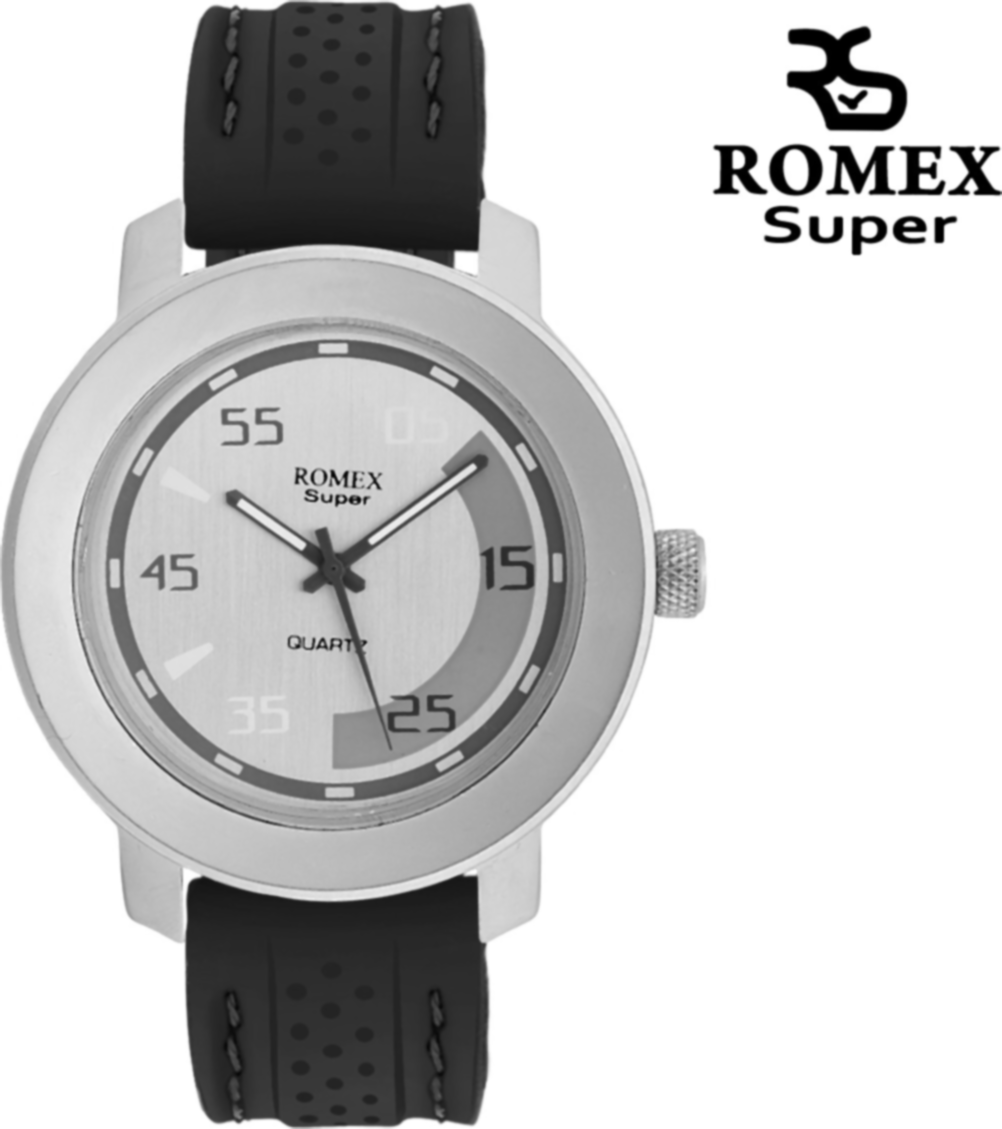

In [12]:
# Affichage d'une image pendant 5000 ms = 5s.
cv2_imshow( images[1])
cv2.waitKey(5000)
cv2.destroyAllWindows()

In [13]:
img_name = []

for j in os.listdir(folder):
    img_name.append(j)
    
df_image_order = pd.DataFrame(img_name)
df_image_order.columns = ['image']

In [14]:
# Dataframe trié par l'ordre des images.
df_product_merged = pd.merge(df_image_order, df_product, left_on = 'image', right_on = 'image')
df_product_merged2 = pd.merge(df_image_order, df_product, left_on = 'image', right_on = 'image')

# Exemple de preprocessing sur une image

Le **preprocessing** sur les images s'articule comme suit:
- Chargement des images en **niveau de gris**
- Application d'un **filtre médian**
- Application d'un **filtre Gaussien**
- Extraction des **descripteurs** de l'image par l'algo **ORB**

**ORB** performs as well as **SIFT** on the task of feature detection (and is better than SURF) while being almost two orders of magnitude faster.

In [15]:
import cv2
import glob

In [16]:
images = [cv2.imread(file) for file in glob.glob("/content/drive/MyDrive/Images/*.jpg")]
len(images)

1050

In [17]:
# Chargement d'image en niveau de gris.
img1 = cv2.imread(r'/content/drive/MyDrive/Images/964648862f322b2cc153239af04b22ef.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(r'/content/drive/MyDrive/Images/9d3ca83f7017d6e9e129964e88503ff0.jpg', cv2.IMREAD_GRAYSCALE)

In [18]:
img1

array([[255, 255, 255, ..., 253, 254, 254],
       [255, 255, 255, ..., 253, 254, 254],
       [255, 255, 255, ..., 253, 254, 254],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [19]:
# Dimension de l'image (en pixel).
img1.shape

(995, 850)

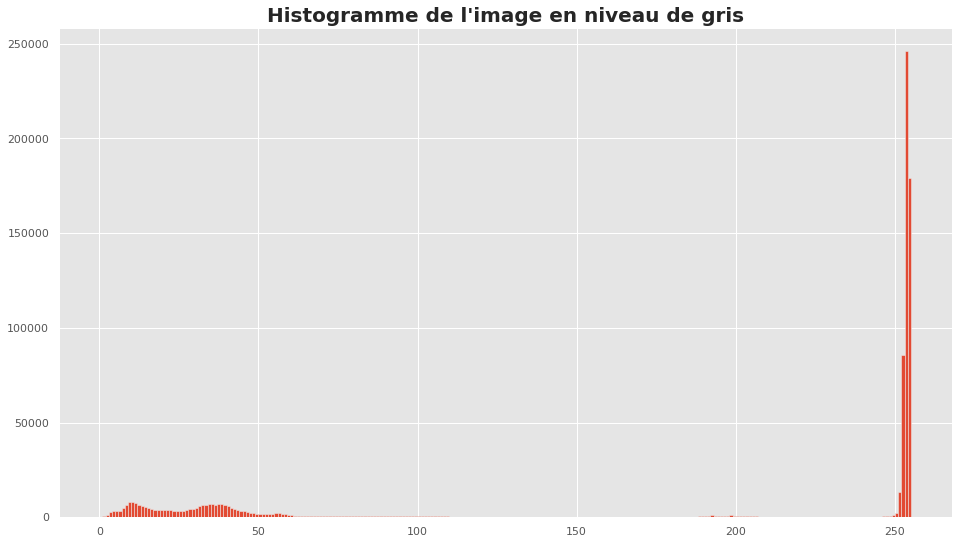

In [20]:
plt.figure(figsize=(16,9))
plt.title("Histogramme de l'image en niveau de gris", weight='bold', size=20)
n, bins, patches = plt.hist(img1.flatten(), bins=range(256))
plt.show()

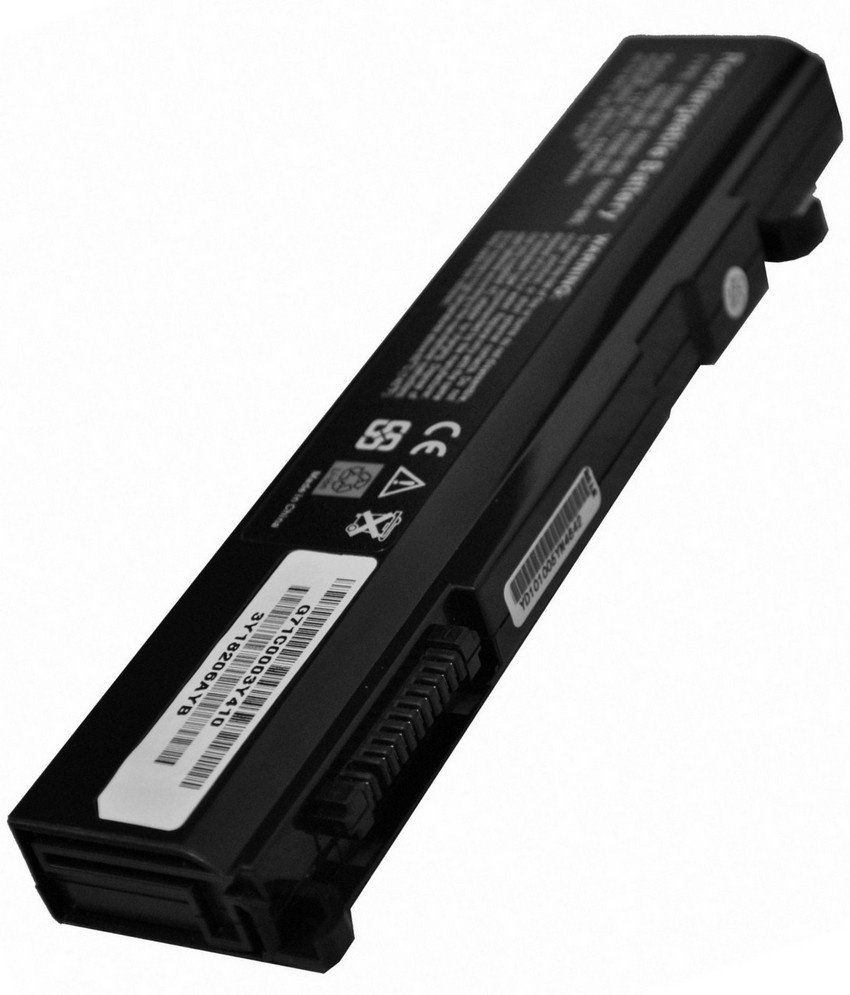

In [21]:
# Affichage de l'image avant filtrage.
cv2_imshow(img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
# Filtrage Median.
img_filtre1 = cv2.medianBlur(img1, 3)

# Filtrage Gaussien.
img_filtre2 = cv2.GaussianBlur(img_filtre1, (5, 5), 1)

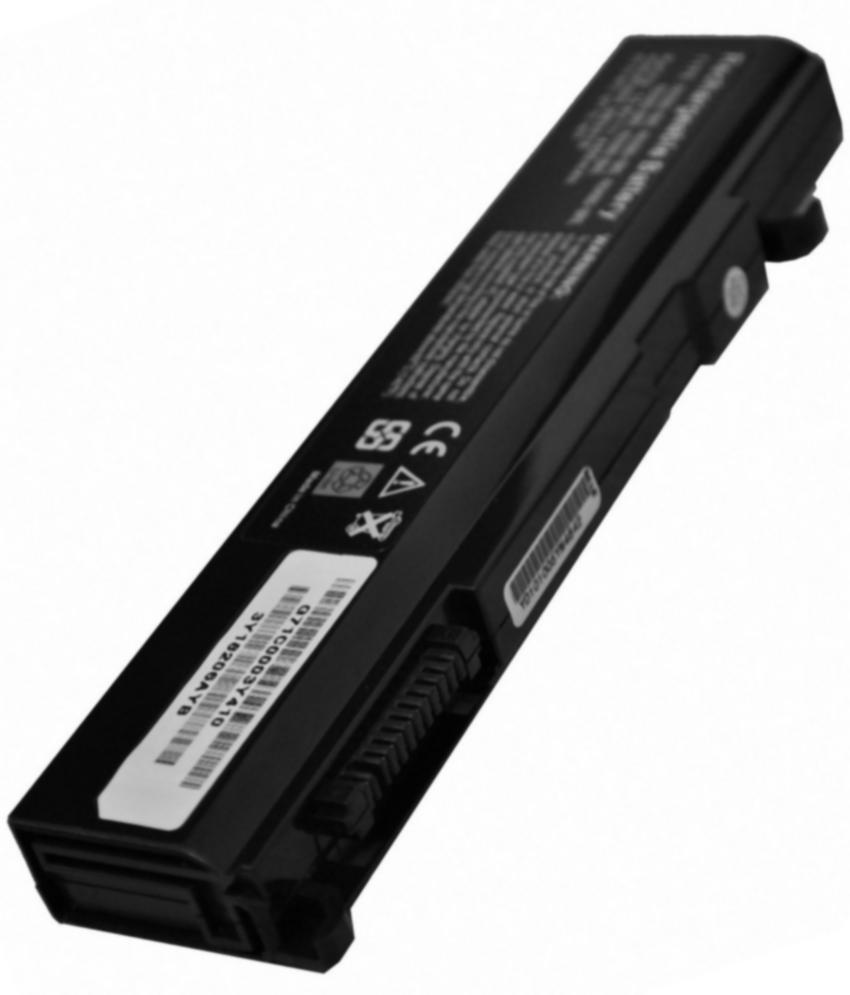

In [23]:
# Affichage de l'image après filtrage
cv2_imshow(img_filtre2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [24]:
def keypoints(image, extractor):
    
    """
    Cette fonction retourne les keypoints de l'image donnée en entrée.
    
    """
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints

In [25]:
# On utilise ici comme extracteur l'algo ORB.
extractor = cv2.ORB_create(nfeatures=1000)

img_1 = cv2.drawKeypoints(img_filtre2, keypoints(img_filtre2, extractor), None, color=(0,255,0), flags=0)

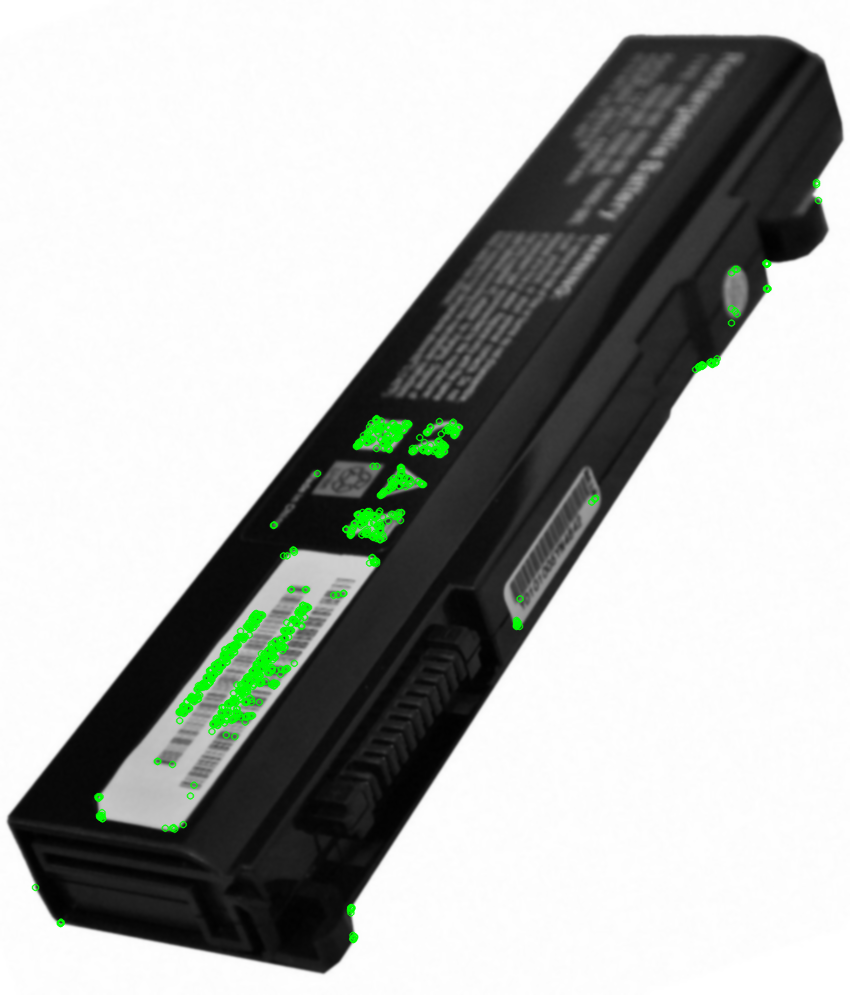

In [26]:
# Affichage de l'image après filtrage
cv2_imshow(img_1)
cv2.waitKey(0)
cv2.destroyAllWindows()

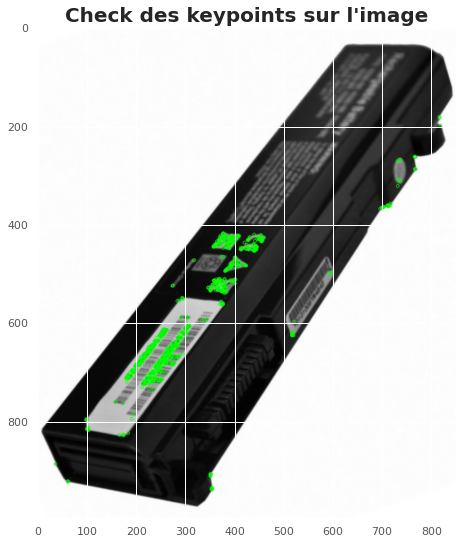

In [27]:
# Affihce de l'image après préprocessing et avec ses keypoints.
plt.title("Check des keypoints sur l'image", weight='bold', size=20)
plt.imshow(img_1)

# Bag of Visual Word

L'objectif de cette parti est d'obtenir un **training/testing set** à partir des images pour pouvoir utiliser des algos supervisés. 
On réalisera donc un **Bag of Visual Word** en utilisant l'algo **ORB**. 
On cherchera à optimiser le nombre de **Visual Word** crée en utilisé un algo de classif et en maximisant **l'accuracy_score** obtenu lors de la classification.

In [28]:
def orb_features(img):
    
    """
    Cette fonction retourne la liste des descripteurs pour chaque images.
    """
    
    # Liste contenant les descripteurs.
    descriptor = []
    
    # Extraction des descripteurs par ORB. (ici 50 descripteurs).
    orb_extractor = cv2.ORB_create(nfeatures=100)
    
    for i in img:
            
        # Keypoints & Descripteurs.
        kp, des = orb_extractor.detectAndCompute(i,None)
        descriptor.append(des)
    
    return descriptor

In [29]:
# Liste des descripteurs de l'ensemble des images.
descriptor_list = orb_features(images)

In [30]:
columns_name = [str(i) for i in range(32)]

columns_name.append('img')

In [31]:
# Réorganisation des descripteurs de chaques images du dataset.

df_courant1 = pd.DataFrame(columns=np.arange(33))

df_courant1.columns = columns_name

# Liste stockant les index des potentiels images sans descripteurs.
img_without_descriptor = []

for i,j in enumerate(descriptor_list):
    
    df_courant2 = pd.DataFrame(j)
    
    if df_courant2.shape[0]!=0:
    
        df_courant3 = pd.concat([df_courant2, pd.Series(np.full(df_courant2.shape[0],i))], axis=1)
        df_courant3.columns = columns_name

        df_courant1 = pd.concat([df_courant1, df_courant3])
    
    else:
        img_without_descriptor.append(i)

In [32]:
# Index des images n'ayant pas de descripteurs trouvés par ORB.
img_without_descriptor

[589]

In [33]:
# Standardisation avant clustering.
S = StandardScaler()
descriptors_standard = S.fit_transform(df_courant1.iloc[:,np.arange(32)])


In [34]:
# Création des visual words via KMeans.
kmeans = KMeans(n_clusters = 750, init='k-means++')
kmeans.fit(descriptors_standard)

KMeans(n_clusters=750)

In [35]:
df_courant1['Labels'] = kmeans.labels_

In [36]:
def complete_list(L):
    
    """
    Cette fonction complete une liste donnée en entrée avec des 0 jusqu'à avoir k éléments dans la liste.
    
    """
    
    L = list(L)
    
    while len(L)<750:
        L.append(0)
        
    return L

In [37]:
# Liste contenant le Bag of Visual Word.
bovw = []

# Création des vecteurs Bovw pour chaque image.
for i in df_courant1['img'].unique():
    bovw.append(complete_list(np.bincount(df_courant1[df_courant1['img']==i]['Labels'])))

In [38]:
df_visual_word = pd.DataFrame(bovw)

# Standardisation.
S = StandardScaler()
df_visual_word = pd.DataFrame(S.fit_transform(df_visual_word))
#todo : regarder le filtrage gaussien , flou, nombre de descripteurs,montrer exemples, réduire graph et images
# regarder artefacts sur le bord des images, montrer descripteurs en plus grands 
# penser aux sections et au sommaire 
# faisabilité du modèle CNN : ARI entre 0.4 et 0.6
# pré-entrainé : utilisé sur des base de données publiques 

In [39]:
# PCA.

composantes = []
for i in range(df_visual_word.shape[1]):
    composantes.append('Principal component ' + str(i))


pca = PCA(n_components=df_visual_word.shape[1])
df_visual_word_pca = pd.DataFrame(pca.fit_transform(df_visual_word))
df_visual_word_pca.columns = composantes

In [40]:
# Combien doit-on garder de composantes principales pour expliquer 95% de la variance du dataset ?

for i,j in enumerate(pca.explained_variance_ratio_.cumsum()):
    if(j>0.95):
        print('Il faut {} composantes pour expliquer 95% de la variance du dataset'.format(i))
        break

Il faut 505 composantes pour expliquer 95% de la variance du dataset


In [41]:
# Réduction au nbr de composantes nécéssaires.
df_visual_word_pca = df_visual_word_pca.iloc[:,np.arange(513)]

# Destruction des lignes ou les produits n'ont pas de descripteur.
df_product_merged.drop(index = img_without_descriptor, inplace = True)
df_product_merged.reset_index(inplace=True, drop=True)

# Ajout de la target : product_category.
df_visual_word_pca['Category'] = df_product_merged['product_category']

# Test d'algo supervisé

In [42]:
# Split en training/testing set.
X_train, X_test, Y_train, Y_test = train_test_split(df_visual_word_pca.iloc[:,:df_visual_word_pca.shape[1] - 1], 
                                                    df_visual_word_pca['Category'], 
                                                    test_size=0.3)

In [43]:
# GridSearch sur la RF.
RForestClassifier = RandomForestClassifier()
gridSearch = GridSearchCV(RForestClassifier, {'max_depth': range(3,6),
                                              'n_estimators': (200,300,500)},
                                              cv=5,
                                              scoring='accuracy')
# Fit sur le training set.
gridSearch.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(3, 6),
                         'n_estimators': (200, 300, 500)},
             scoring='accuracy')

In [44]:
# Accuracy sur l'approche supervisée.
prediction = gridSearch.best_estimator_.predict(X_test)
accuracy_score(Y_test, prediction)

0.2761904761904762

### Matrice de confusion

In [45]:
categ_unique = df_product.product_category.unique()

df_real_label_ytest = pd.DataFrame(Y_test)
df_prediction = pd.DataFrame(gridSearch.best_estimator_.predict(X_test))

df_real_label_ytest.reset_index(inplace = True, drop = True)

df_compare = pd.concat([df_real_label_ytest, df_prediction], axis=1)
df_compare.columns = ['product_category', 'prediction']

In [46]:
def dico_to_list(dico):
    
    """
    Cette fonction retourne les valeurs d'un dictionnaire sous forme d'une liste.
    
    """
    
    L=[]
    for key, value in dico.items():
        L.append(value)
    return L

In [47]:
# Création de la matrice de confusion.

df_matrice_confusion = pd.DataFrame(columns=categ_unique,index=categ_unique)

for i in categ_unique:
    
    dico ={j:0 for j in categ_unique}
    
    mask = (df_compare['product_category']==i)
    mask2 = (df_compare['product_category']!=df_compare['prediction'])
    
    dico[i] = df_compare[mask].shape[0] - df_compare[mask & mask2].shape[0]
    
    for k in df_compare[mask & mask2].prediction:
        dico[k]+=1
    
    df_matrice_confusion.loc[i,:] = dico_to_list(dico)

df_matrice_confusion = df_matrice_confusion[df_matrice_confusion.columns].astype(float)

Text(0.5, 84.5, 'Prediction')

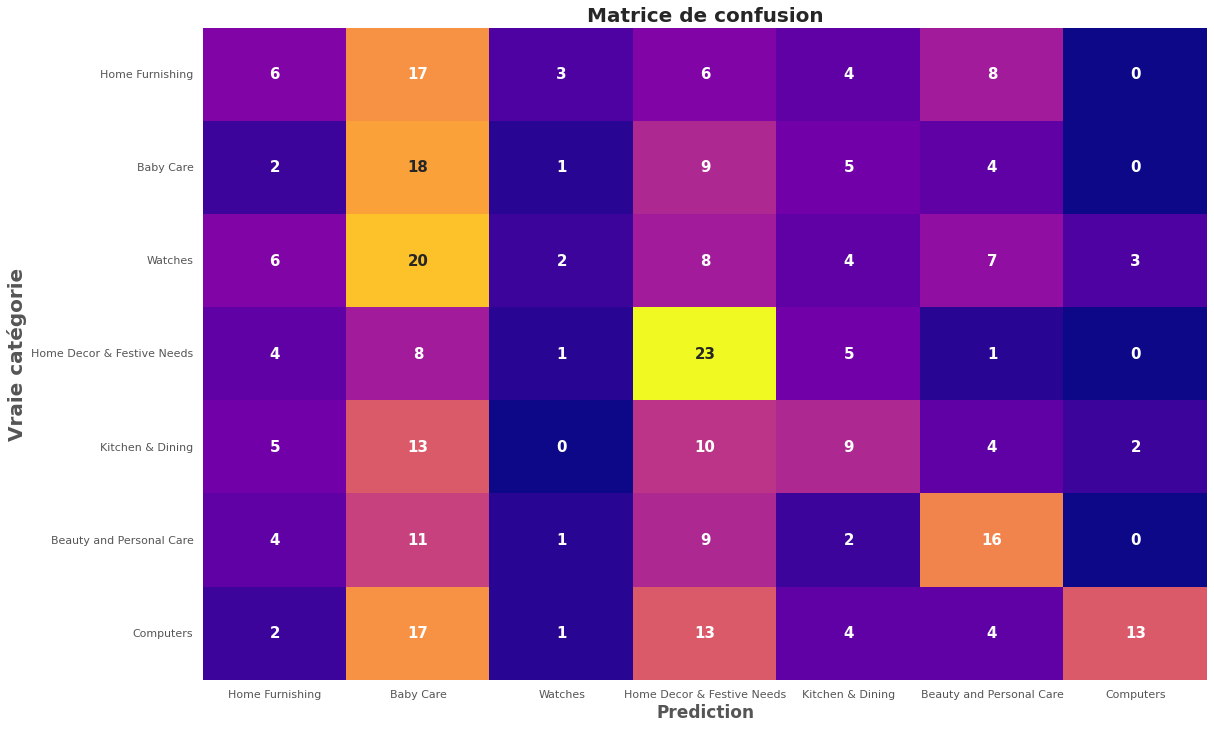

In [48]:
plt.figure(figsize=(18,12))
plt.title('Matrice de confusion', size=20, weight='bold')
sns.heatmap(df_matrice_confusion,
            xticklabels=True, 
            yticklabels= True, 
            annot=True,
            cmap="plasma", cbar=False,
            annot_kws={"size": 15, 'weight' : 'bold'})
plt.ylabel("Vraie catégorie", weight='bold', size=20)
plt.xlabel('Prediction', weight='bold', size=17)

## Clustering

In [49]:
km = KMeans(n_clusters=7, 
            init='k-means++',
            random_state=2)

km.fit(df_visual_word_pca.iloc[:,np.arange(df_visual_word_pca.shape[1]-1)])

KMeans(n_clusters=7, random_state=2)

In [50]:
df_visual_word_pca['Labels'] = km.labels_
df_visual_word_pca.groupby('Labels').size()

Labels
0    264
1     20
2    334
3    105
4    244
5      7
6     75
dtype: int64

### Visualisation

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Viz ACP with Kmeans')

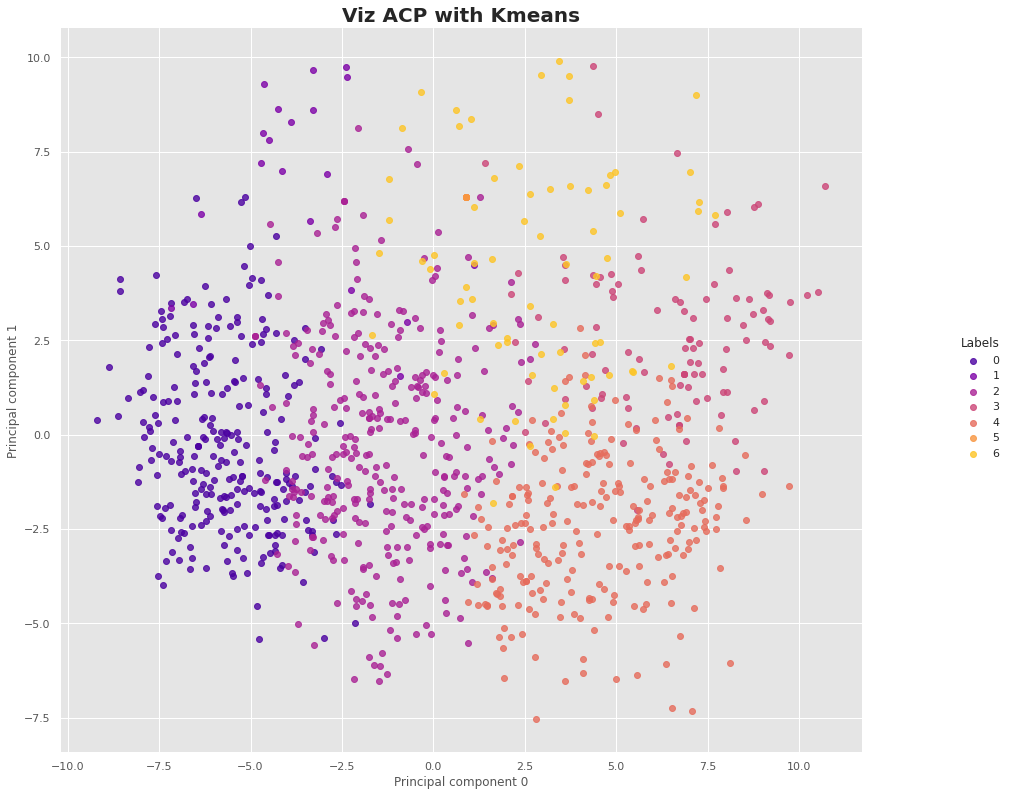

In [51]:
sns.lmplot(x='Principal component 0', 
            y='Principal component 1', 
            hue='Labels', 
            data=df_visual_word_pca,
            palette = 'plasma',
            fit_reg=False,
            legend=True, 
            legend_out=True)

plt.gcf().set_size_inches(16, 12)
plt.title('Viz ACP with Kmeans',size=20, weight='bold')

In [52]:
# Calcul des composantes TSNE.
tsne = TSNE(n_components=2, perplexity=50)
tsne_results = tsne.fit_transform(df_visual_word_pca.iloc[:,:513])

df_visual_word_pca['TSNE_2D_one'] = tsne_results[:,0]
df_visual_word_pca['TSNE_2D_two'] = tsne_results[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Viz ACP/T-Sne')

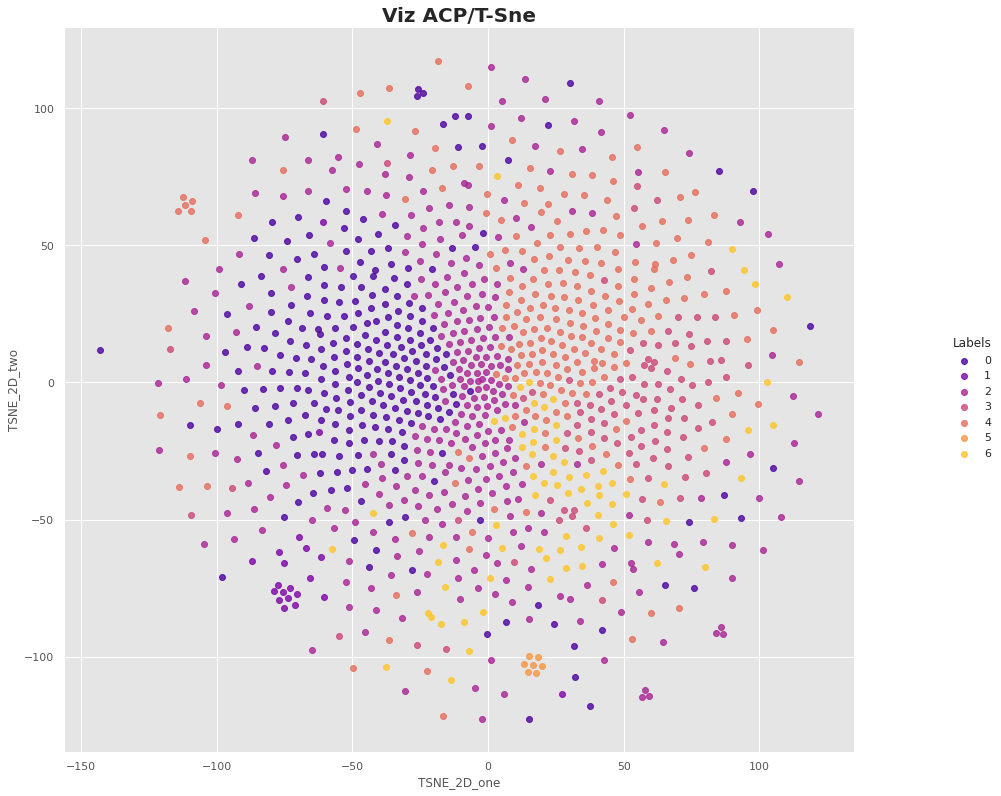

In [53]:
sns.lmplot(x='TSNE_2D_one', 
           y='TSNE_2D_two', 
           hue='Labels', 
           data=df_visual_word_pca,
           palette = 'plasma',
           fit_reg=False,
           legend=True, 
           legend_out=True)

plt.gcf().set_size_inches(16, 12)
plt.title('Viz ACP/T-Sne',size=20, weight='bold')

## Mesure de qualité du clustering

In [54]:
# Indice de Rand ajusté.
adjusted_rand_score(df_visual_word_pca.Labels, df_visual_word_pca.Category)

0.029084244885680257

In [55]:
silhouette_score(df_visual_word_pca.iloc[:,:513], df_visual_word_pca.Labels)

0.017431736137458433